<a href="https://colab.research.google.com/github/oceam/agri-image/blob/main/codes/VegAnn_tuturial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a tuturial code for the VggAnn (https://github.com/simonMadec/VegAnn) deep learning networks

> **VegAnn**   
> Vegetation Annotation of a large multi-crop RGB Dataset acquired under diverse conditions for image semantic segmentation
>https://www.nature.com/articles/s41597-023-02098-y  
>https://zenodo.org/records/7636408

# Hidden Codes

All the codes used in this course are hidden here, this may cost a few minutes, please wait patiently

In [4]:
!pip install torch
!pip install pytorch-lightning
!pip install segmentation_models_pytorch

In [5]:
!git clone https://github.com/simonMadec/VegAnn.git

fatal: destination path 'VegAnn' already exists and is not an empty directory.


In [6]:
def colorTransform_VegGround(im,X_true,alpha_vert,alpha_g):
    alpha = alpha_vert
    color = np.array([97,65,38]) / 255
    image=np.copy(im)
    for c in range(3):
        image[:, :, c] =np.where(X_true == 0,image[:, :, c] *(1 - alpha) + alpha * color[c] ,image[:, :, c])
    alpha = alpha_g
    color = np.array([34,139,34]) / 255
    for c in range(3):
        image[:, :, c] =np.where(X_true == 1,image[:, :, c] *(1 - alpha) + alpha * color[c] ,image[:, :, c])
    return image

In [7]:
def resize_image(image, ratio):
    new_shape = (
        int(np.ceil(image.shape[0] / ratio) * ratio),
        int(np.ceil(image.shape[1] / ratio) * ratio),
        image.shape[2]
    )

    trans = transform.resize(image, new_shape, anti_aliasing=True)

    return trans

In [8]:
def split_tensor(tensor, tile_size=256):
    mask = torch.ones_like(tensor)
    # use torch.nn.Unfold
    stride  = tile_size//2
    unfold  = torch.nn.Unfold(kernel_size=(tile_size, tile_size), stride=stride)
    # Apply to mask and original image
    mask_p  = unfold(mask)
    patches = unfold(tensor)

    patches = patches.reshape(3, tile_size, tile_size, -1).permute(3, 0, 1, 2)
    patch_bool_size = [patches.shape[0], 1, patches.shape[2], patches.shape[3]]
    if tensor.is_cuda:
        patches_base = torch.zeros(patch_bool_size, device=tensor.get_device()).bool()
    else:
        patches_base = torch.zeros(patch_bool_size).bool()

    tiles = []
    for t in range(patches.size(0)):
         tiles.append(patches[[t], :, :, :])
    return tiles, mask_p, patches_base, (tensor.size(2), tensor.size(3))

def rebuild_tensor(tensor_list, mask_t, base_tensor, t_size, tile_size=256):
    stride  = tile_size//2
    # base_tensor here is used as a container

    for t, tile in enumerate(tensor_list):
        #  print(tile.size())
         base_tensor[[t], :, :] = tile

    base_tensor = base_tensor.permute(1, 2, 3, 0).reshape(1*tile_size*tile_size, base_tensor.size(0)).unsqueeze(0)
    fold = torch.nn.Fold(output_size=(t_size[0], t_size[1]), kernel_size=(tile_size, tile_size), stride=stride)

    # output_tensor = fold(base_tensor)/fold(mask_t)
    output_tensor = fold(base_tensor.float())
    return output_tensor.bool()

# Start using

import some basic dependency packages

In [9]:
import pytorch_lightning as pl
import torch
import segmentation_models_pytorch as smp
import numpy as np
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import matplotlib.pyplot as plt
from typing import Dict, List
from skimage import transform
import torch.nn.functional as F
from tqdm import tqdm

import VegAnn model from the cloned folder `VegAnn/vegann/utils`

In [10]:
import os
import sys
sys.path.insert(0, 'VegAnn/vegann/utils')

from vegan_model import VegAnnModel

## Download Model weights from google drive

In [11]:
!gdown https://drive.google.com/uc?id=1azagsinfW4btSGaTi0XJKsRnFR85Gtaw
ckt_path = "/content/VegAnn.ckpt"


Downloading...
From: https://drive.google.com/uc?id=1azagsinfW4btSGaTi0XJKsRnFR85Gtaw
To: /content/VegAnn.ckpt
100% 294M/294M [00:04<00:00, 69.3MB/s]


## Download demo images

Create the folder to put images for processing

In [12]:
if not os.path.exists('imgs'):
  os.mkdir('imgs')

Download one test img to processing folder

In [13]:
!gdown https://drive.google.com/uc?id=1QUkhkLI3Qk9gZgjW0TIEh2LrC8IXntMD -O 'imgs/test.png'

Downloading...
From: https://drive.google.com/uc?id=1QUkhkLI3Qk9gZgjW0TIEh2LrC8IXntMD
To: /content/imgs/test.png
100% 411k/411k [00:00<00:00, 128MB/s]


load the weight of VggAnn model, after executing this block, it will print out the model structure and loaded weight

In [14]:
checkpoint = torch.load(ckt_path, map_location=torch.device('cuda'))
model = VegAnnModel("Unet","resnet34",in_channels = 3, out_classes=1 )
model.load_state_dict(checkpoint["state_dict"])
preprocess_fn = smp.encoders.get_preprocessing_fn("resnet34", pretrained= "imagenet")
model.eval()

VegAnnModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

## Predict one image

The follow block shows how to load the image to memory

In [15]:
im = plt.imread('imgs/test.png')

Show the image size and how it looks like

In [16]:
im.shape

(512, 512, 3)

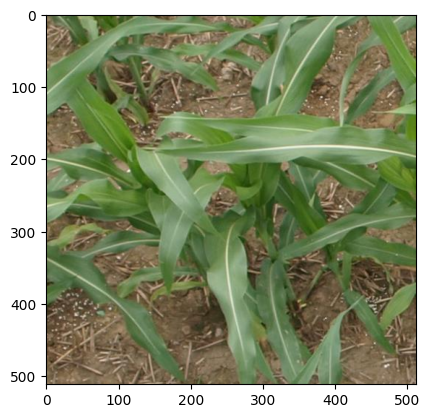

In [17]:
plt.imshow(im)

and use the VggAnn to predict the final results

In [18]:
def predict_one_img(im):
    preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
    image = preprocess_input(im)
    image = image.astype('float32')

    inputs = torch.tensor(image) # , dtype=float
    inputs = inputs.permute(2,0,1)
    inputs = inputs[None,:,:,:]
    logits = model(inputs)
    pr_mask = logits.sigmoid()

    pred = (pr_mask > 0.5).numpy().astype(np.uint8)

    return pred

In [19]:
pred = predict_one_img(im)

pred

array([[[[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]], dtype=uint8)

The outputs is a black and white image with 0 and 1

## Visualize the results

In [20]:
pred.shape

(1, 1, 512, 512)

We can see, it is an image with 512 and 512 size, but the `(1, 1` is not necessary, we can disard them by slicing `[0,0, :, :]`

In [21]:
pred[0,0,:,:].shape

(512, 512)

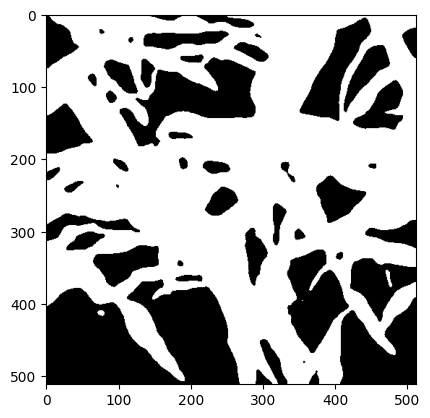

In [22]:
plt.imshow(pred[0,0,:,:], cmap='gray')

To better visualize the result on raw image, you can using the following code:

In [23]:
def better_show_results(im, pred):
    im1_pred = colorTransform_VegGround(im,pred,0.8,0.2)
    im2_pred = colorTransform_VegGround(im,pred,0.2,0.8)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 5))
    ax1.imshow(im)
    ax1.set_title("Input Image")

    ax2.imshow(im2_pred)
    ax2.set_title("Prediction")

    ax3.imshow(im1_pred)
    ax3.set_title("Prediction")

    plt.show()

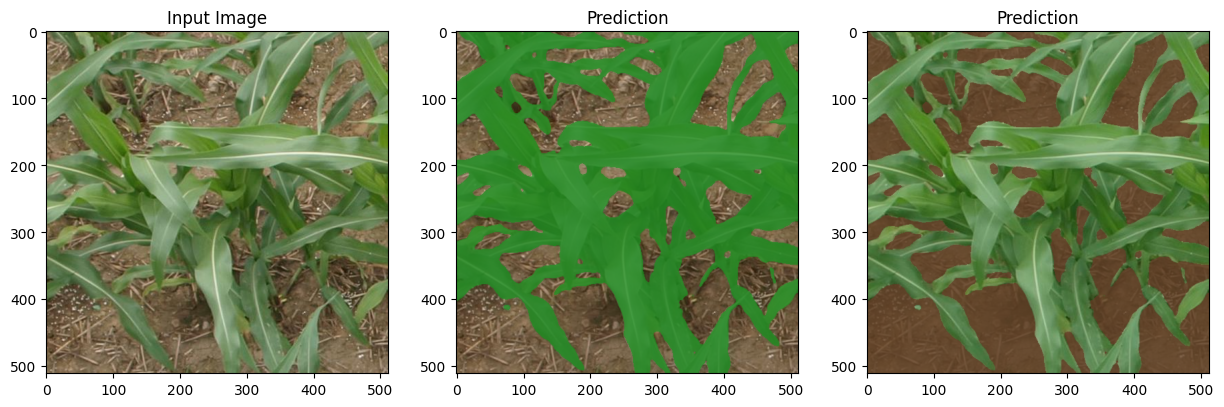

In [24]:
better_show_results(im, pred)

# 練習  
自分の画像を入力してみる

download image

In [29]:
!gdown --id 1rlMmWCpSsZ94-t50IRM6iwvuIdF6e-Ak
!unzip ccexample.zip


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rlMmWCpSsZ94-t50IRM6iwvuIdF6e-Ak
To: /content/ccexample.zip
100% 20.1M/20.1M [00:00<00:00, 42.7MB/s]
Archive:  ccexample.zip
   creating: ccexample/broccoli/
  inflating: ccexample/broccoli/200421_11_DJI_0402.csv  
  inflating: ccexample/broccoli/200421_11_DJI_0402.JPG  
  inflating: ccexample/broccoli/200422_11_DJI_0206.csv  
  inflating: ccexample/broccoli/200422_11_DJI_0206.JPG  
  inflating: ccexample/broccoli/200427_11_DJI_0654.csv  
  inflating: ccexample/broccoli/200427_11_DJI_0654.JPG  
  inflating: ccexample/broccoli/200430_11_DJI_0413.csv  
  inflating: ccexample/broccoli/200430_11_DJI_0413.JPG  
  inflating: ccexample/broccoli/200508_11_DJI_0400.csv  
  inflating: ccexample/broccoli/200508_11_DJI_0400.JPG  
 ex

In [25]:
im_self = plt.imread('ccexample/broccoli/200421_11_DJI_0402.JPG')
im_self.shape

(1500, 1500, 3)

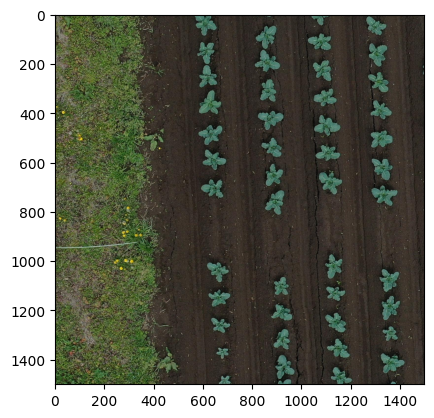

In [26]:
im_self=im_self[ :, :,0:3]
plt.imshow(im_self)

In [27]:
pred = predict_one_img(im_self)

pred

RuntimeError: ignored

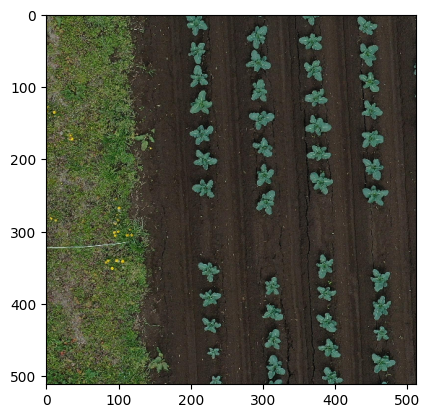

In [28]:
import cv2
im_self2 = cv2.resize(im_self, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
plt.imshow(im_self2)


In [29]:
pred_self2 = predict_one_img(im_self2)

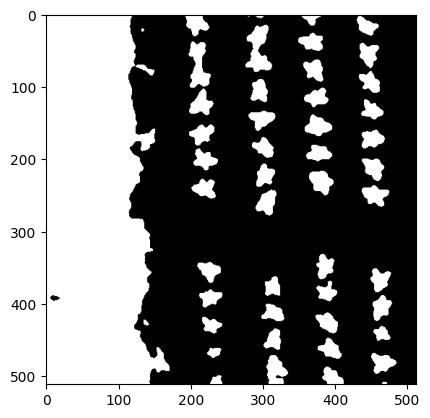

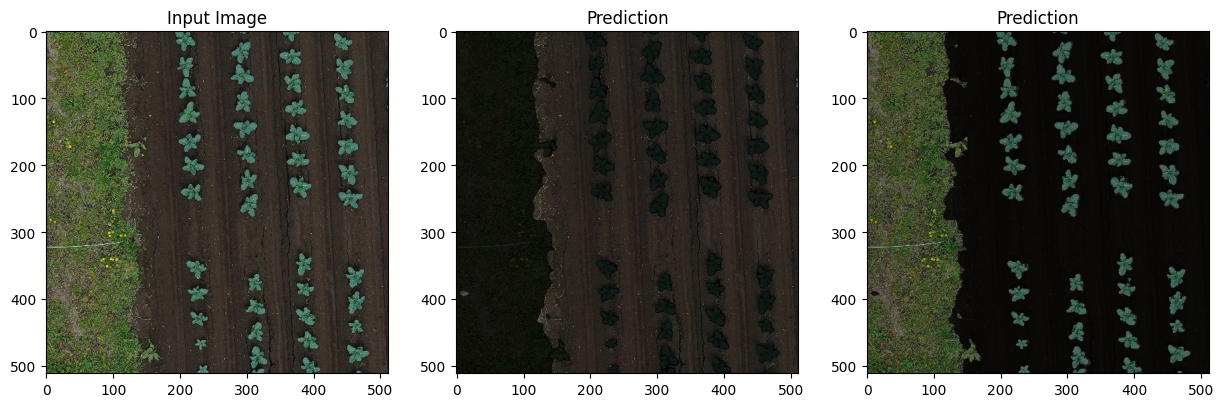

In [30]:
plt.imshow(pred_self2[0,0,:,:], cmap='gray')
better_show_results(im_self2, pred_self2)

# 拡張練習

*But* one limitation of deep learning is, the image size is strictly limited, for example, here is one image with 2250x4000:

In [31]:
!gdown --fuzzy https://drive.google.com/file/d/1yCALVBnexXvrcX86b1bGSwpQazuSQhP3/view?usp=share_link -O 'imgs/uav.jpg'

Downloading...
From: https://drive.google.com/uc?id=1yCALVBnexXvrcX86b1bGSwpQazuSQhP3
To: /content/imgs/uav.jpg
100% 4.22M/4.22M [00:00<00:00, 37.9MB/s]


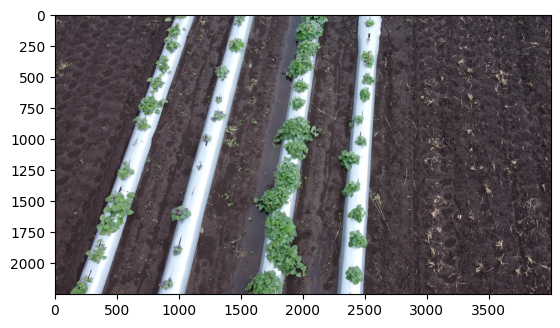

In [32]:
import cv2
im2=plt.imread('imgs/uav.jpg')
im2 = cv2.normalize(im2.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
plt.imshow(im2)


When try to run it directly:

```python
im2_pred = predict_one_img(im2)
```

It will given the following error:

```python
...
/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/model.py in check_input_shape(self, x)
     17             new_h = (h // output_stride + 1) * output_stride if h % output_stride != 0 else h
     18             new_w = (w // output_stride + 1) * output_stride if w % output_stride != 0 else w
---> 19             raise RuntimeError(
     20                 f"Wrong input shape height={h}, width={w}. Expected image height and width "
     21                 f"divisible by {output_stride}. Consider pad your images to shape ({new_h}, {new_w})."

RuntimeError: Wrong input shape height=2250, width=4000. Expected image height and width divisible by 32. Consider pad your images to shape (2272, 4000).
```

To fix it, using the following DIY function to resize it to a proper size

In [33]:
im2_trans = resize_image(im2, 32*16)   # Expected image height and width divisible by 32, times 16 to make later processing faster
im2_trans.shape

(2560, 4096, 3)

However, feeding such 2272 x 4000 directly into DL model will run out memeory, so need to split to small sectors to process and then merge them back

Reference: [pytorch unfold：extract patches from image | Bowenroom](https://bowenroom.github.io/myBlog/pytorch/fastai2/2020/06/01/torch-unfold.html)

In [34]:
def predict_one_large_img(image, patch_size):
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).unsqueeze(0).float()

    # split to small tensors
    tile_tensors, mask_t, base_tensor, t_size = split_tensor(image_tensor, patch_size)

    # predict each tensor
    mask_container = []
    for i in tqdm(tile_tensors):
        # do prediction
        logits = model(i)
        pr_mask = logits.sigmoid()
        pred = (pr_mask > 0.5).bool()

        mask_container.append(pred)

    # merge all results
    output_tensor = rebuild_tensor(mask_container, mask_t, base_tensor, t_size, patch_size)

    return output_tensor.numpy().astype(np.uint8)

In [35]:
im2_pred = predict_one_large_img(im2_trans, 32*16)

100%|██████████| 135/135 [02:12<00:00,  1.02it/s]


In [36]:
im2_pred.shape

(1, 1, 2560, 4096)

Also, remember to reshape results to origial image size

In [37]:
im2_pred_origin = transform.resize(im2_pred[0,0,:,:], im2.shape[0:2])
im2_pred_origin2 = cv2.normalize(im2_pred_origin.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

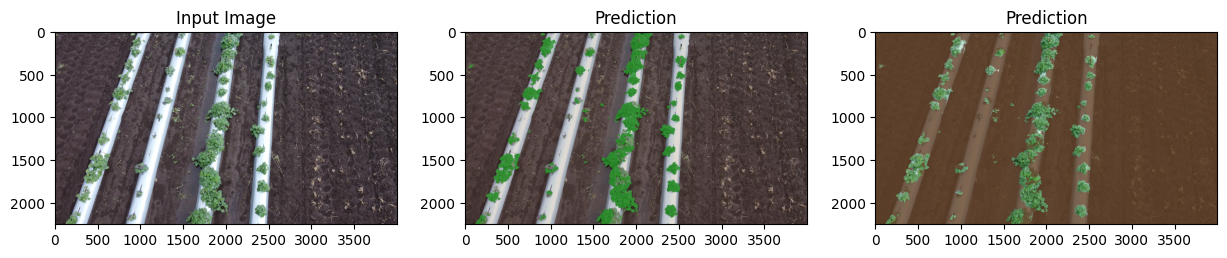

In [38]:
better_show_results(im2, im2_pred_origin2)